## Evaluating the Predictive Power of Expected Goals (xG) in European Football Analysis



## Table of Contents
- [Introduction](#intro)
- [Part I - Data Collection & Wrangling](#collect)
- [Part II - Exploratory Analysis & Cleaning](#explore)
- [Part III - Binary Logistic Regression & Correlation](#binary)
- [Part IIII - Multinomial Logistic Regression & Correlation](#multinomial)


<a id='intro'></a>
### Introduction

Understanding the predictive power of performance metrics in football can significantly enhance strategic decisions made by coaches, analysts, and managers. Traditional metrics like possession and shots on target have long been used to gauge team performance, but the xG metric, which quantifies the quality of goal-scoring opportunities, offers a potentially more nuanced insight. By comparing the predictive accuracy of xG with that of traditional metrics, this study aims to provide empirical evidence on the most reliable indicators of match outcomes. 


In [1]:
# import libraries
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

<a id='collect'></a>
### Data Collection & Wrangling

In [2]:
# define path
path = './*.csv'

# use glob to get all csv file paths
csv_files = glob.glob(path)

# loop through file paths and read each into dataframe
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)
    
# concat all dfs into singal frame
all_data = pd.concat(dfs, ignore_index = True)

# display
print(all_data.head())

   Rk           Team       Date   xG Unnamed: 4            Opp        Comp  \
0   1  Hellas Verona  6/11/2023  0.8          @         Spezia  it Serie A   
1   2         Spezia  6/11/2023  1.9        NaN  Hellas Verona  it Serie A   
2   3    Real Madrid   6/4/2023  1.8        NaN  Athletic Club  es La Liga   
3   4       Juventus   6/4/2023  1.3          @        Udinese  it Serie A   
4   5  Athletic Club   6/4/2023  2.3          @    Real Madrid  es La Liga   

  Result  GF  GA  ...  A-xAG  npxG/Sh  Sh  G/Sh  G/SoT  SoT  SoT%  Dist  FK  \
0  W 3-1   3   1  ...    1.4     0.08   9  0.33   0.60    5  55.6  16.8   0   
1  L 1-3   1   3  ...    0.3     0.09  16  0.06   0.13    8  50.0  18.0   1   
2  D 1-1   1   1  ...   -0.9     0.12   8  0.00   0.00    1  12.5  17.9   0   
3  W 1-0   1   0  ...   -0.1     0.06  20  0.05   0.20    5  25.0  14.2   1   
4  D 1-1   1   1  ...   -1.0     0.12  14  0.07   0.13    8  57.1  18.6   0   

   Match Report  
0  Match Report  
1  Match Report  
2 

In [3]:
# save to new csv
all_data.to_csv('combined_data.csv', index=False)

In [4]:
# load combined csv
data = pd.read_csv('combined_data.csv')

data.head()

,Rk,Team,Date,xG,Unnamed: 4,Opp,Comp,Result,GF,GA,...,A-xAG,npxG/Sh,Sh,G/Sh,G/SoT,SoT,SoT%,Dist,FK,Match Report
0,1,Hellas Verona,6/11/2023,0.8,@,Spezia,it Serie A,W 3-1,3,1,...,1.4,0.08,9,0.33,0.60,5,55.6,16.8,0,Match Report
1,2,Spezia,6/11/2023,1.9,NaN,Hellas Verona,it Serie A,L 1-3,1,3,...,0.3,0.09,16,0.06,0.13,8,50.0,18.0,1,Match Report
2,3,Real Madrid,6/4/2023,1.8,NaN,Athletic Club,es La Liga,D 1-1,1,1,...,-0.9,0.12,8,0.00,0.00,1,12.5,17.9,0,Match Report
3,4,Juventus,6/4/2023,1.3,@,Udinese,it Serie A,W 1-0,1,0,...,-0.1,0.06,20,0.05,0.20,5,25.0,14.2,1,Match Report
4,5,Athletic Club,6/4/2023,2.3,@,Real Madrid,es La Liga,D 1-1,1,1,...,-1.0,0.12,14,0.07,0.13,8,57.1,18.6,0,Match Report


<a id='explore'></a>
### Exploratory Analysis & Cleaning

In [5]:
# summary stats
data.describe()

,Rk,xG,GF,GA,GD,Poss,G-PK,PK,PKatt,PKm,...,np:G-xG,A-xAG,npxG/Sh,Sh,G/Sh,G/SoT,SoT,SoT%,Dist,FK
count,3654.00000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,...,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3542.000000,3654.000000,3654.000000,3654.000000,3654.000000
mean,1827.50000,1.366557,1.383963,1.381773,0.002189,50.040777,1.217570,0.121237,0.158456,0.037219,...,-0.026546,-0.055473,0.102545,12.363711,0.104124,0.299678,4.140668,33.816612,17.619184,0.422551
std,1054.96327,0.775189,1.245446,1.246339,1.844041,11.114600,1.185046,0.345196,0.400948,0.190766,...,0.984882,0.870153,0.043863,5.099278,0.103438,0.270682,2.387673,15.789446,3.084250,0.644542
min,1.00000,0.000000,0.000000,0.000000,-9.000000,19.000000,0.000000,0.000000,0.000000,0.000000,...,-2.800000,-3.100000,0.010000,1.000000,0.000000,0.000000,0.000000,0.000000,7.500000,0.000000
25%,914.25000,0.800000,0.000000,0.000000,-1.000000,42.000000,0.000000,0.000000,0.000000,0.000000,...,-0.700000,-0.600000,0.070000,9.000000,0.000000,0.000000,2.000000,23.100000,15.600000,0.000000
50%,1827.50000,1.200000,1.000000,1.000000,0.000000,50.000000,1.000000,0.000000,0.000000,0.000000,...,-0.100000,-0.200000,0.090000,12.000000,0.090000,0.250000,4.000000,33.300000,17.500000,0.000000
75%,2740.75000,1.800000,2.000000,2.000000,1.000000,58.000000,2.000000,0.000000,0.000000,0.000000,...,0.500000,0.400000,0.130000,15.000000,0.170000,0.500000,6.000000,42.900000,19.300000,1.000000
max,3654.00000,5.300000,9.000000,9.000000,9.000000,81.000000,8.000000,2.000000,3.000000,2.000000,...,5.800000,4.000000,0.410000,35.000000,0.800000,1.000000,20.000000,100.000000,54.900000,4.000000


In [6]:
# objects and counts
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3654 entries, 0 to 3653
Data columns (total 34 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rk            3654 non-null   int64  
 1   Team          3654 non-null   object 
 2   Date          3654 non-null   object 
 3   xG            3654 non-null   float64
 4   Unnamed: 4    1823 non-null   object 
 5   Opp           3654 non-null   object 
 6   Comp          3654 non-null   object 
 7   Result        3654 non-null   object 
 8   GF            3654 non-null   int64  
 9   GA            3654 non-null   int64  
 10  GD            3654 non-null   int64  
 11  Poss          3654 non-null   int64  
 12  G-PK          3654 non-null   int64  
 13  PK            3654 non-null   int64  
 14  PKatt         3654 non-null   int64  
 15  PKm           3654 non-null   int64  
 16  xG.1          3654 non-null   float64
 17  npxG          3654 non-null   float64
 18  xGD           3654 non-null 

In [7]:
# keep only needed columns
df = data[['xG', 'Result','Poss', 'SoT']]

print(df)

       xG Result  Poss  SoT
0     0.8  W 3-1    32    5
1     1.9  L 1-3    68    8
2     1.8  D 1-1    64    1
3     1.3  W 1-0    57    5
4     2.3  D 1-1    36    8
...   ...    ...   ...  ...
3649  1.6  D 1-1    61    6
3650  0.7  L 1-2    57    3
3651  0.6  D 2-2    47    4
3652  0.4  L 0-3    20    1
3653  1.7  L 1-3    54    3

[3654 rows x 4 columns]


<a id='binary'></a>
### Binary Logistic Regression & Correlation

In [8]:
# Binary Logistic Regression

# copy df
df_binary = df.copy()

# map 'Result' to binary outcomes: Win = 1, Not Win = 0
df_binary['Result_binary'] = df_binary['Result'].str[0].map({'W': 1, 'D': 0, 'L': 0})

print(df_binary)

       xG Result  Poss  SoT  Result_binary
0     0.8  W 3-1    32    5              1
1     1.9  L 1-3    68    8              0
2     1.8  D 1-1    64    1              0
3     1.3  W 1-0    57    5              1
4     2.3  D 1-1    36    8              0
...   ...    ...   ...  ...            ...
3649  1.6  D 1-1    61    6              0
3650  0.7  L 1-2    57    3              0
3651  0.6  D 2-2    47    4              0
3652  0.4  L 0-3    20    1              0
3653  1.7  L 1-3    54    3              0

[3654 rows x 5 columns]


Optimization terminated successfully.
         Current function value: 0.548122
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          Result_binary   No. Observations:                 3654
Model:                          Logit   Df Residuals:                     3650
Method:                           MLE   Df Model:                            3
Date:                Thu, 23 May 2024   Pseudo R-squ.:                  0.1733
Time:                        23:09:06   Log-Likelihood:                -2002.8
converged:                       True   LL-Null:                       -2422.8
Covariance Type:            nonrobust   LLR p-value:                9.710e-182
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7503      0.181     -9.647      0.000      -2.106      -1.395
xG             1.0000      0.

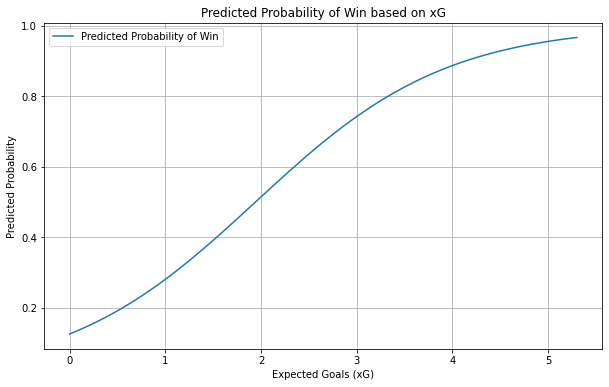

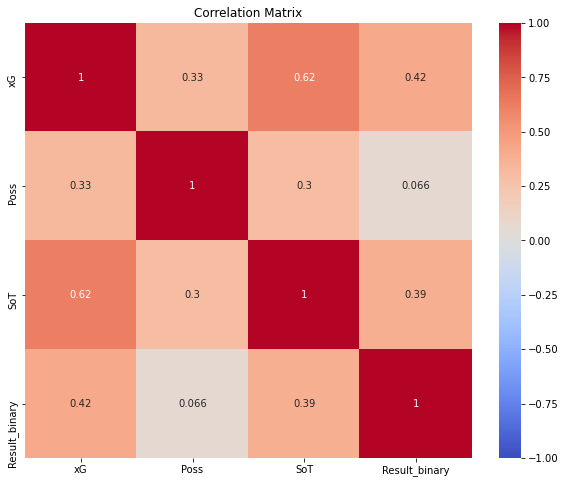

In [9]:
# define the predictors and the outcome
X = df_binary[['xG', 'Poss', 'SoT']]
y = df_binary['Result_binary']

# add a constant to the predictors (required for the logistic regression)
X = sm.add_constant(X)

# fit the logistic regression model
model = sm.Logit(y, X)
result = model.fit()

# print the summary of the logistic regression
print(result.summary())

# create range of xG values for prediction
xG_values = np.linspace(df_binary['xG'].min(), df_binary['xG'].max(), 100)

# create df with xG_values and average values for Poss and SoT
X_pred = pd.DataFrame({
    'const': 1,
    'xG': xG_values,
    'Poss': np.full_like(xG_values, df_binary['Poss'].mean()),
    'SoT': np.full_like(xG_values, df_binary['SoT'].mean())
})

# calculate predicted probablilites
predicted_probs = result.predict(X_pred)

# plotting the predicated probabilities
plt.figure(figsize=(10, 6))
plt.plot(xG_values, predicted_probs, label='Predicted Probability of Win')
plt.xlabel('Expected Goals (xG)')
plt.ylabel('Predicted Probability')
plt.title('Predicted Probability of Win based on xG')
plt.legend()
plt.grid(True)
plt.show()

# Correlation matrix
correlation_matrix = df_binary[['xG', 'Poss', 'SoT', 'Result_binary']].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

#### Notes
Model:
- Log-Likelihood: Fitted model provides better fit than null model
- Pseudo R-squared: 0.1733 - model has some explanatory power
- LLP p-value: model is statistically significant

Regression:
- xG: p-value <0.0001. Highly significant predictor
- Poss: Negative coefficient. p-value <0.0001. Statistically significant
- SoT: p-value <0.0001. Highly significant predictor

Correlation Matrix:
- xG: moderate correlation 0.42
- Poss: weak correlation 0.066
- SoT: moderal correlation 0.39

<a id='multinomial'></a>
### Multinomial Logistic Regression & Correlation

In [10]:
# Multinomial Logistic Regression

# copy df
df_multi = df.copy()

# Map 'Result' to multinomial outcomes: Win = 2, Draw = 1, Loss = 0
df_multi['Result_multi'] = df_multi['Result'].str[0].map({'W': 2, 'D': 1, 'L': 0})

print(df_multi)

       xG Result  Poss  SoT  Result_multi
0     0.8  W 3-1    32    5             2
1     1.9  L 1-3    68    8             0
2     1.8  D 1-1    64    1             1
3     1.3  W 1-0    57    5             2
4     2.3  D 1-1    36    8             1
...   ...    ...   ...  ...           ...
3649  1.6  D 1-1    61    6             1
3650  0.7  L 1-2    57    3             0
3651  0.6  D 2-2    47    4             1
3652  0.4  L 0-3    20    1             0
3653  1.7  L 1-3    54    3             0

[3654 rows x 5 columns]


Optimization terminated successfully.
         Current function value: 0.950051
         Iterations 5
                          MNLogit Regression Results                          
Dep. Variable:           Result_multi   No. Observations:                 3654
Model:                        MNLogit   Df Residuals:                     3646
Method:                           MLE   Df Model:                            6
Date:                Thu, 23 May 2024   Pseudo R-squ.:                  0.1204
Time:                        23:13:36   Log-Likelihood:                -3471.5
converged:                       True   LL-Null:                       -3946.6
Covariance Type:            nonrobust   LLR p-value:                5.245e-202
Result_multi=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.0661      0.202     -5.276      0.000      -1.462      -0.670
xG               

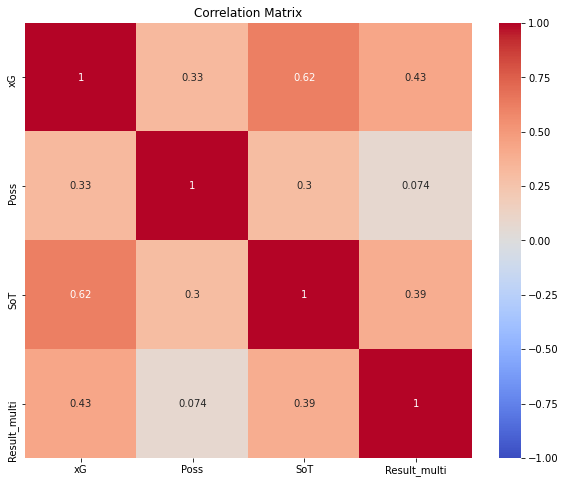

In [11]:
# Define the predictors and the outcome
X = df_multi[['xG', 'Poss', 'SoT']]
y = df_multi['Result_multi']

# Add a constant to the predictors
X = sm.add_constant(X)

# Fit the multinomial logistic regression model
model = sm.MNLogit(y, X)
result = model.fit()

# Print the summary of the multinomial logistic regression
print(result.summary())

# Correlation matrix
correlation_matrix = df_multi[['xG', 'Poss', 'SoT', 'Result_multi']].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

#### Notes
Model:
- Log-Likelihood: Fitted model provides better fit than null model
- Pseudo R-squared: 0.1204 - model has some explanatory power
- LLP p-value: model is statistically significant

Regression:

Draw vs Loss
- xG: 0.6422 - significantly increases likelihood of draw
- Poss: -0.0066 - decreases but not significant
- SoT: 0.0664 - increases but only slightly

Win vs Loss
- xG: 1.3154 - significantly increases likelihood of win
- Poss: -0.0276 - decreases likelihood
- SoT: 0.2781 - significantly increases likelihood of win

Correlation Matrix:
- xG: moderate correlation 0.43
- Poss: very weak correlation 0.074
- SoT: moderal correlation 0.39